# Projet final du Kit Data Science 2020- Roberto NOBREGA

### Modules utilisés

In [242]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import urllib.request
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objects as go
from ipyleaflet import Map, Icon, basemaps, Marker, LayerGroup,basemap_to_tiles, Polyline, LegendControl, WidgetControl
from datetime import datetime, timedelta
import datetime
import pyproj
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import IntSlider, ColorPicker, jslink
%matplotlib inline

### Fonctions

In [243]:
def get_soup_from_url(url):
    res = requests.get(url)
    soup = BeautifulSoup(res.content, 'html.parser')
    return soup

def get_specs_from_url(url):
    soup = get_soup_from_url(url)
    specs_table = soup.find_all('li',class_="skipper-boat-list-specs-list__item")
    nom_col = []
    lista = []
    for item in specs_table:
        nom_col.append(str(item).split(':')[0].split('>')[1])
        lista.append(str(item).split(':')[1].split('<')[0])
    df = pd.DataFrame(lista, nom_col)
    return df

hora = ['04', '08', '11', '14', '17', '21', '23']
def dia_hora():
    AUJ = datetime.date.today().strftime("%Y%m%d")
    for i in range(len(hora)):
        if (datetime.datetime.now().strftime("%H") < hora[i]):
            if (hora[i] == '04'):
                H = '21'
                AUJ = str(int(AUJ) - 1)
                break
            else:
                H = hora[i-1]
                break
    return [AUJ, H]

def Grand_index(vector):
    for i,item in enumerate(vector): 
        if item < 0.02:
            break
    return i

def String2Lat(lat):
    out = float(lat.split("°")[0]) + float(lat.split("°")[1].split("'")[0])/60
    if (lat.split("°")[1].split("'")[1] == 'S'):
        out = (-1)*out
    return out
def String2Long(longitude):
    out = float(longitude.split("°")[0]) + float(longitude.split("°")[1].split("'")[0])/60
    if (longitude.split("°")[1].split("'")[1] == 'W'):
        out = (-1)*out
    return out

def get_workable_url(AUJ, H):
    URL = f"https://www.vendeeglobe.org/download-race-data/vendeeglobe_{AUJ}_{H}0000.xlsx"
    if (requests.head(URL).status_code == 404):
        if (H == '04'):
            H = '21'
            AUJ= str(int(AUJ) - 1)
        else:
            indice = hora.index(H)
            H = hora[indice -1]
    return f"https://www.vendeeglobe.org/download-race-data/vendeeglobe_{AUJ}_{H}0000.xlsx"

### Import et traitement du  classement

Chargement du URL correct

In [244]:
AUJ, H = dia_hora()
URL = get_workable_url(AUJ, H)

Chargement du tableau de classification et éditions

In [245]:
classif = pd.read_excel(URL, names = ['0','Rang','Nat et Voile', 'Skipper et Bateau', 'Heure FR','Latitude', 'Longitude', 
         'Cap Depuis 30min (°)', 'Vitesse Depuis 30min(kts)', 'VMG Depuis 30min(kts)','Distance Depuis 30min(nm)',
        'Cap Depuis Dernier Class(°)', 'Vitesse Depuis Dernier Class(kts)', 'VMG Depuis Dernier Class(kts)','Distance Depuis Dernier Class(nm)',
        'Cap Depuis 24h(°)', 'Vitesse Depuis 24h(kts)', 'VMG Depuis 24h(kts)','Distance Depuis 24h(nm)',
        'DTF(nm)', 'DTL(nm)'], skiprows=[0,1,2,3,38,39,40] )
classif = classif.iloc[:, 1:]
classif = classif.dropna()
classif = classif.set_index(classif['Rang'])
classif['Nat et Voile'] = classif['Nat et Voile'].apply(lambda x : x.split('\n')[1])
classif['Skipper et Bateau'] = classif['Skipper et Bateau'].apply(lambda x : x.split('\n')[0] + " avec " + x.split('\n')[1].upper())
classif['Skipper et Bateau'] = classif['Skipper et Bateau'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
classif['Heure FR'] = classif['Heure FR'].apply(lambda x : x.split('\n')[0])
classif['Cap Depuis 30min (°)'] = classif['Cap Depuis 30min (°)'].apply(lambda x : x.split('°')[0])
classif['Vitesse Depuis 30min(kts)'] = classif['Vitesse Depuis 30min(kts)'].apply(lambda x : x.split(' ')[0])
classif['VMG Depuis 30min(kts)'] = classif['VMG Depuis 30min(kts)'].apply(lambda x : x.split(' ')[0])
classif['Distance Depuis 30min(nm)'] = classif['Distance Depuis 30min(nm)'].apply(lambda x : x.split(' ')[0])
classif['Cap Depuis Dernier Class(°)'] = classif['Cap Depuis Dernier Class(°)'].apply(lambda x : x.split('°')[0])
classif['Vitesse Depuis Dernier Class(kts)'] = classif['Vitesse Depuis Dernier Class(kts)'].apply(lambda x : x.split(' ')[0])
classif['VMG Depuis Dernier Class(kts)'] = classif['VMG Depuis Dernier Class(kts)'].apply(lambda x : x.split(' ')[0])
classif['Distance Depuis Dernier Class(nm)'] = classif['Distance Depuis Dernier Class(nm)'].apply(lambda x : x.split(' ')[0])
classif['Cap Depuis 24h(°)'] = classif['Cap Depuis 24h(°)'].apply(lambda x : x.split('°')[0])
classif['Vitesse Depuis 24h(kts)'] = classif['Vitesse Depuis 24h(kts)'].apply(lambda x : x.split(' ')[0])
classif['VMG Depuis 24h(kts)'] = classif['VMG Depuis 24h(kts)'].apply(lambda x : x.split(' ')[0])
classif['Distance Depuis 24h(nm)'] = classif['Distance Depuis 24h(nm)'].apply(lambda x : x.split(' ')[0])
classif['DTF(nm)'] = classif['DTF(nm)'].apply(lambda x : x.split(' ')[0])
classif['DTL(nm)'] = classif['DTL(nm)'].apply(lambda x : x.split(' ')[0])
classif['Skipper']= classif['Skipper et Bateau'].apply(lambda x: x.split('avec')[0].strip())
classif.head()

,Rang,Nat et Voile,Skipper et Bateau,Heure FR,Latitude,Longitude,Cap Depuis 30min (°),Vitesse Depuis 30min(kts),VMG Depuis 30min(kts),Distance Depuis 30min(nm),...,Vitesse Depuis Dernier Class(kts),VMG Depuis Dernier Class(kts),Distance Depuis Dernier Class(nm),Cap Depuis 24h(°),Vitesse Depuis 24h(kts),VMG Depuis 24h(kts),Distance Depuis 24h(nm),DTF(nm),DTL(nm),Skipper
Rang,,,,,,,,,,,,,,,,,,,,,
1,1,FRA 79,Charlie Dalin avec APIVIA,17:30 FR,38°00.81'S,09°12.33'E,61,17.3,11.1,8.7,...,16.6,11.7,49.7,64,18.7,13.5,449.6,18016.4,0.0,Charlie Dalin
2,2,FRA 59,Thomas Ruyant avec LINKEDOUT,16:30 FR,38°43.76'S,02°03.84'E,121,17.3,17.1,8.7,...,16.8,15.9,33.5,75,16.9,13.7,406.0,18314.8,298.5,Thomas Ruyant
3,3,FRA 85,Kevin Escoffier avec PRB,17:30 FR,39°19.40'S,01°09.02'E,108,18.7,18.6,9.3,...,19.1,19.1,57.2,88,17.6,16.0,422.1,18342.2,325.8,Kevin Escoffier
4,4,FRA 01,Jean Le Cam avec YES WE CAM !,17:30 FR,38°42.18'S,01°26.35'E,108,17.0,17.0,8.5,...,17.1,17.1,51.4,99,16.2,15.6,387.7,18342.7,326.4,Jean Le Cam
5,5,FRA 17,Yannick Bestaven avec MAITRE COQ IV,17:30 FR,38°28.04'S,00°32.20'E,112,17.1,17.1,8.5,...,18.0,17.6,53.9,80,17.2,14.5,413.1,18387.3,371.0,Yannick Bestaven


### Import et traitement des fiches techniques des bateaux

In [246]:
base = 'https://www.vendeeglobe.org/fr/skippers/'
URL_list=['88/arnaud-boissieres','105/charlie-dalin','114/clement-giraud', '116/jean-le-cam',
          '99/alan-roura','90/sebastien-simon','108/nicolas-troussel','110/romain-attanasio','106/louis-burton',
         '97/sam-davies','120/pip-hare','94/stephane-le-diraison','113/thomas-ruyant','107/maxime-sorel', '100/alexia-barrier',
          '123/didac-costa','117/sebastien-destremau','109/boris-herrmann','104/miranda-merron','111/damien-seguin',
          '122/alex-thomson','91/yannick-bestaven', '92/manuel-cousin', '112/benjamin-dutreux', '124/ari-huusela', 
          '96/giancarlo-pedote', '119/kojiro-shiraishi','101/armel-tripon','103/jeremie-beyou', '95/clarisse-cremer',
         '89/kevin-escoffier','102/isabelle-joschke']
specs =  get_specs_from_url(base+'93/fabrice-amedeo').transpose()
specs['Skipper'] = "Fabrice Amedeo"
for item in URL_list:
    temp = get_specs_from_url(base+item).transpose()
    temp['Skipper'] = item.split('/')[1].replace("-", " ").title()
    specs = pd.concat([specs,temp])
specs.iloc[10,14] = 'Samantha Davies'
specs['Longueur ']= specs['Longueur '].apply(lambda x : x.split('m')[0].replace(',', '.'))
specs['Largeur ']= specs['Largeur '].apply(lambda x : x.split('m')[0].replace(',', '.'))
specs['Déplacement (poids) ']= specs['Déplacement (poids) '].apply(lambda x : x.split(" ")[1].replace(',', '.'))
for i in [8,15,29]:
    specs.iloc[i,8] = str(specs.iloc[i,8]).split('t')[0]
specs['Déplacement (poids) ']= specs['Déplacement (poids) '].str.replace('NC','8.2')
specs['Déplacement (poids) ']= specs['Déplacement (poids) '].str.replace('nc','8.2')
specs["Tirant d'eau "]= specs["Tirant d'eau "].apply(lambda x : x.split('m')[0].replace(',', '.'))
specs['Hauteur mât ']= specs['Hauteur mât '].apply(lambda x : x.split('m')[0].replace(',', '.'))
specs['Surface de voiles au près ']= specs['Surface de voiles au près '].apply(lambda x : x.split('m')[0])
specs['Surface de voiles au portant ']= specs['Surface de voiles au portant '].apply(lambda x : x.split('m')[0])
specs.columns = ['Numéro de voile','Anciens noms du bateau','Architecte','Chantier','Date de lancement',
 'Longueur (m)','Largeur (m)',"Tirant d'eau (m)",'Déplacement (poids) (t)','Nombre de dérives','Hauteur mât (m)',
 'Voile quille','Surface de voiles au près (m2)','Surface de voiles au portant (m2)','Skipper']
specs['Nombre de dérives']= specs['Nombre de dérives'].str.replace('foils','1')
specs['Nombre de dérives']= specs['Nombre de dérives'].str.replace(' foiler',' 1')
specs['Nombre de dérives']= specs['Nombre de dérives'].str.replace('2','2')
specs['Nombre de dérives']= specs['Nombre de dérives'].str.replace('2 asymétriques','2')
specs['Nombre de dérives'] = pd.to_numeric(specs['Nombre de dérives'],errors='coerce')
specs.head()

,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur (m),Largeur (m),Tirant d'eau (m),Déplacement (poids) (t),Nombre de dérives,Hauteur mât (m),Voile quille,Surface de voiles au près (m2),Surface de voiles au portant (m2),Skipper
0,FRA 56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,01 Août 2015,18.28,5.85,4.50,7,1,29,monotype,320,570,Fabrice Amedeo
0,FRA 14,"Ecover3, Président, Gamesa, Kilcullen Voyager...",Owen Clarke Design LLP - Clay Oliver,Hakes Marine - Mer Agitée,03 Août 2007,18.28,5.65,4.50,7.9,1,29,basculante avec vérin,300,610,Arnaud Boissieres
0,FRA 79,NaN,Verdier,CDK technologies - MerConcept,05 Août 2019,18.28,5.85,4.50,8,1,29,acier,350,560,Charlie Dalin
0,FRA83,"Delta Dore, Bureau Vallée, Vers un Monde sans...",Bruce Farr design,JMV Cherbourg,26 Juillet 2006,18.28,5.75,4.50,8.5,2,29,acier forgé,300,620,Clement Giraud
0,001,"Cheminées Poujoulat, Mare, Maître CoQ, Mapfre...",Bruce Farr design,CDK Technologies,03 Janvier 2007,18.28,5.90,4.50,8,2,28,acier forgé,300,620,Jean Le Cam


### Combinaision des tableaux de classement et de fiches techniques

In [247]:
Class_Specs = classif.merge(specs, on="Skipper", how = 'inner')
Class_Specs.head()

,Rang,Nat et Voile,Skipper et Bateau,Heure FR,Latitude,Longitude,Cap Depuis 30min (°),Vitesse Depuis 30min(kts),VMG Depuis 30min(kts),Distance Depuis 30min(nm),...,Date de lancement,Longueur (m),Largeur (m),Tirant d'eau (m),Déplacement (poids) (t),Nombre de dérives,Hauteur mât (m),Voile quille,Surface de voiles au près (m2),Surface de voiles au portant (m2)
0,1,FRA 79,Charlie Dalin avec APIVIA,17:30 FR,38°00.81'S,09°12.33'E,61,17.3,11.1,8.7,...,05 Août 2019,18.28,5.85,4.50,8,1,29,acier,350,560
1,2,FRA 59,Thomas Ruyant avec LINKEDOUT,16:30 FR,38°43.76'S,02°03.84'E,121,17.3,17.1,8.7,...,03 Septembre 2019,18.28,5.85,4.50,8,1,29,acier forgé,350,560
2,3,FRA 85,Kevin Escoffier avec PRB,17:30 FR,39°19.40'S,01°09.02'E,108,18.7,18.6,9.3,...,08 Mars 2010,18.28,5.50,4.50,8.2,1,27.40,Acier mécano soudé,300,600
3,4,FRA 01,Jean Le Cam avec YES WE CAM !,17:30 FR,38°42.18'S,01°26.35'E,108,17.0,17.0,8.5,...,03 Janvier 2007,18.28,5.90,4.50,8,2,28,acier forgé,300,620
4,5,FRA 17,Yannick Bestaven avec MAITRE COQ IV,17:30 FR,38°28.04'S,00°32.20'E,112,17.1,17.1,8.5,...,12 Mars 2015,18.28,5.80,4.50,8,1,29,acier mécano soudé,310,550


### Corrélation VMG avec Rang

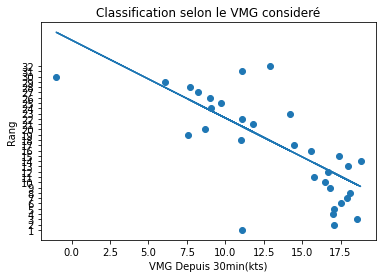

intercept: 35.91 m: -1.47 coeff. de det: 0.55


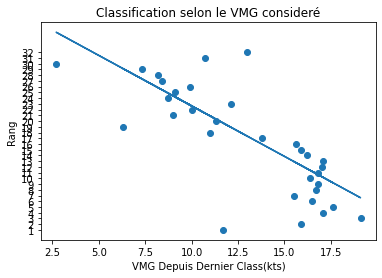

intercept: 39.25 m: -1.76 coeff. de det: 0.6


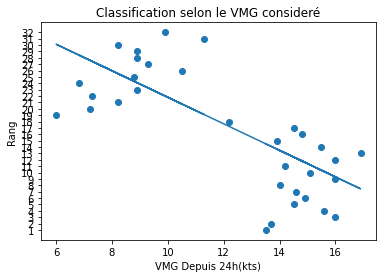

intercept: 41.59 m: -2.08 coeff. de det: 0.56


In [248]:
noms = ['VMG Depuis 30min(kts)', 'VMG Depuis Dernier Class(kts)', 'VMG Depuis 24h(kts)']  
y = Class_Specs.iloc[:,0]

for i in [8,12,16]:
    x = Class_Specs.iloc[:, i].tolist()
    x = np.array(x).reshape((-1, 1)).astype(np.float64)
    model = LinearRegression().fit(x,y)
    r_sq = model.score(x, y)
    plt.scatter(x,y)
    y_pred = model.predict(x)
    plt.plot(x, y_pred)
    plt.xlabel(noms[int((i-8)/4)])
    plt.ylabel('Rang')
    plt.title('Classification selon le VMG consideré')
    plt.show()
    print('intercept:', round(model.intercept_,2), 'm:', round(model.coef_[0],2),'coeff. de det:', round(r_sq,2))

### Vérification de la relation entre les bateaux ayant des foils ou non avec leur rang

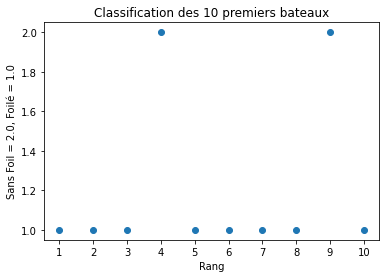

In [249]:
plt.scatter(Class_Specs.loc[:9,'Rang'],Class_Specs.loc[:9,'Nombre de dérives'])
plt.title('Classification des 10 premiers bateaux')
plt.xlabel('Rang')
plt.ylabel('Sans Foil = 2.0, Foilé = 1.0')
plt.show()

### Etude statistique des variables explicatives indépendantes

Conversion à float des valeurs numeriques du tableau combiné

In [250]:
cs=(Class_Specs.columns).tolist()
cs2 = cs[6:20] + cs[26:30] + cs[31:32] + cs[33:]
X = Class_Specs[cs2]
Y = Class_Specs['Rang']
Y = pd.to_numeric(Y)
X= X.apply(pd.to_numeric, errors='coerce')

In [251]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32 entries, 0 to 31
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Cap Depuis 30min (°)               32 non-null     int64  
 1   Vitesse Depuis 30min(kts)          32 non-null     float64
 2   VMG Depuis 30min(kts)              32 non-null     float64
 3   Distance Depuis 30min(nm)          32 non-null     float64
 4   Cap Depuis Dernier Class(°)        32 non-null     int64  
 5   Vitesse Depuis Dernier Class(kts)  32 non-null     float64
 6   VMG Depuis Dernier Class(kts)      32 non-null     float64
 7   Distance Depuis Dernier Class(nm)  32 non-null     float64
 8   Cap Depuis 24h(°)                  32 non-null     int64  
 9   Vitesse Depuis 24h(kts)            32 non-null     float64
 10  VMG Depuis 24h(kts)                32 non-null     float64
 11  Distance Depuis 24h(nm)            32 non-null     float64
 

Sommaire des statistiques

In [252]:
X.describe()

,Cap Depuis 30min (°),Vitesse Depuis 30min(kts),VMG Depuis 30min(kts),Distance Depuis 30min(nm),Cap Depuis Dernier Class(°),Vitesse Depuis Dernier Class(kts),VMG Depuis Dernier Class(kts),Distance Depuis Dernier Class(nm),Cap Depuis 24h(°),Vitesse Depuis 24h(kts),...,Distance Depuis 24h(nm),DTF(nm),DTL(nm),Longueur (m),Largeur (m),Tirant d'eau (m),Déplacement (poids) (t),Hauteur mât (m),Surface de voiles au près (m2),Surface de voiles au portant (m2)
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.00000,32.000000,...,32.000000,32.000000,32.000000,32.00,32.000000,32.0,32.000000,32.000000,32.000000,32.00000
mean,135.656250,15.046875,13.178125,7.518750,136.906250,14.593750,12.918750,43.246875,134.68750,14.284375,...,342.656250,19363.959375,1347.612500,18.28,5.710313,4.5,8.150000,28.434375,302.031250,589.53125
std,42.565024,3.127916,4.709889,1.564616,39.515909,2.850347,4.117346,8.657534,46.50594,2.467741,...,59.347446,1006.943805,1006.919107,0.00,0.158042,0.0,0.489898,0.814628,30.529187,48.13220
min,61.000000,7.000000,-1.000000,3.500000,65.000000,7.700000,2.700000,23.100000,64.00000,7.900000,...,188.900000,18016.400000,0.000000,18.28,5.300000,4.5,7.000000,26.000000,240.000000,470.00000
25%,103.500000,13.525000,9.550000,6.750000,104.000000,12.575000,9.700000,37.050000,99.00000,12.400000,...,296.750000,18494.975000,478.675000,18.28,5.600000,4.5,7.800000,28.000000,287.500000,560.00000
50%,119.500000,15.600000,14.350000,7.800000,120.000000,15.400000,13.400000,44.800000,110.00000,14.600000,...,350.600000,18867.350000,851.000000,18.28,5.775000,4.5,8.000000,29.000000,300.000000,590.00000
75%,172.500000,17.375000,17.100000,8.725000,174.750000,16.800000,16.550000,50.225000,185.25000,16.350000,...,392.225000,20257.550000,2241.150000,18.28,5.850000,4.5,8.500000,29.000000,320.000000,610.00000
max,244.000000,18.900000,18.800000,9.400000,216.000000,19.100000,19.100000,57.200000,201.00000,18.700000,...,449.600000,21320.100000,3303.700000,18.28,5.900000,4.5,9.000000,29.000000,365.000000,700.00000


In [253]:
Y.describe()

count    32.000000
mean     16.500000
std       9.380832
min       1.000000
25%       8.750000
50%      16.500000
75%      24.250000
max      32.000000
Name: Rang, dtype: float64

Normalisation du DataFrame

In [254]:
var_explicatives = X
l= X.columns.tolist()
x = X.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X = pd.DataFrame(x_scaled)
X.set_axis(l, axis='columns', inplace=True)

In [255]:
X.describe()

,Cap Depuis 30min (°),Vitesse Depuis 30min(kts),VMG Depuis 30min(kts),Distance Depuis 30min(nm),Cap Depuis Dernier Class(°),Vitesse Depuis Dernier Class(kts),VMG Depuis Dernier Class(kts),Distance Depuis Dernier Class(nm),Cap Depuis 24h(°),Vitesse Depuis 24h(kts),...,Distance Depuis 24h(nm),DTF(nm),DTL(nm),Longueur (m),Largeur (m),Tirant d'eau (m),Déplacement (poids) (t),Hauteur mât (m),Surface de voiles au près (m2),Surface de voiles au portant (m2)
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,...,32.000000,32.000000,32.000000,32.0,32.000000,32.0,32.000000,32.000000,32.000000,32.000000
mean,0.407958,0.676208,0.716067,0.681144,0.476200,0.604715,0.623095,0.590817,0.515967,0.591146,...,0.589782,0.407894,0.407910,0.0,0.683854,0.0,0.575000,0.811458,0.496250,0.519701
std,0.232596,0.262850,0.237873,0.265189,0.261695,0.250030,0.251058,0.253887,0.339459,0.228495,...,0.227647,0.304793,0.304785,0.0,0.263404,0.0,0.244949,0.271543,0.244233,0.209270
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.232240,0.548319,0.532828,0.550847,0.258278,0.427632,0.426829,0.409091,0.255474,0.416667,...,0.413694,0.144860,0.144891,0.0,0.500000,0.0,0.400000,0.666667,0.380000,0.391304
50%,0.319672,0.722689,0.775253,0.728814,0.364238,0.675439,0.652439,0.636364,0.335766,0.620370,...,0.620253,0.257575,0.257590,0.0,0.791667,0.0,0.500000,1.000000,0.480000,0.521739
75%,0.609290,0.871849,0.914141,0.885593,0.726821,0.798246,0.844512,0.795455,0.885036,0.782407,...,0.779919,0.678376,0.678376,0.0,0.916667,0.0,0.750000,1.000000,0.640000,0.608696
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


Séparation du dataset en "train" et "test" pour calibrer le modèle

In [256]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, train_size = 0.65)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Application de PCA "naïve"

In [257]:
#IL FAUT EXECUTER DEUX FOIS CETTE CELL POUR QUE L'ALGORITHME CONVERGE

#Matrice de Covariance
covX = np.cov(X_train, rowvar =False, ddof =1)

#Valeurs et vecteurs propres
valPropCovX, vectPropCovX = np.linalg.eig(np.array(covX.tolist(), dtype=float))

#Extraction des valeurs réelles
vpcovX = list(map(lambda x: x.real, valPropCovX))
vectpcovX = list(map(lambda x: x.real, vectPropCovX))

#Séléction des variables (il y un total)
vp = pd.DataFrame(vectpcovX)
V1k = vp[0:Grand_index(vpcovX)].T
XV = np.dot(X_train,V1k)
pca = LinearRegression(fit_intercept=True,n_jobs=-1)
pca.fit(X=XV,y=y_train)
ols = LinearRegression(fit_intercept=True,n_jobs=-1)
ols.fit(X=X_train,y=y_train)
xvtest = np.dot(X_test,V1k)
res_pca = pca.predict(xvtest) - y_test
res_ols = ols.predict(X_test) - y_test
r2_pca = r2_score(y_test, pca.predict(xvtest))
r2_ols = r2_score(y_test, ols.predict(X_test))
print('Coefficient de détermination avec PCA =', round(r2_pca,3))
print('Coefficient de détermination sans PCA =', round(r2_ols,3))
#Risque de prédiction calculé en utilisant les résidus avec PCA
risque_pca_pred = sum(res_pca**2) / len(y_test)
print('Risque de prédiction pour PCA',round(risque_pca_pred,0))

#Risque de prédiction calculé en utilisant les résidus sans PCA
risque_ols_pred = sum(res_ols**2) / len(y_test)
print('Risque de prédiction pour OLS sans PCA ',round(risque_ols_pred,0))

Coefficient de détermination avec PCA = 0.66
Coefficient de détermination sans PCA = -0.331
Risque de prédiction pour PCA 29.0
Risque de prédiction pour OLS sans PCA  115.0


In [258]:
#Méthode de Forward pour la sélection des variables avec le plus grand score. A chaque boucle, nous calculons 
#le score pour chacune des variables et nous gardons la variable avec le plus grand score T. Nous réduisons Y 
#de la valeur prédite et nous refaisons la même procédure en fonction du nombre de variables explicatives.
#Y = df['Y']
var_a_expliquer = Y
score = {}
e = np.array([[1.0],[0.0]])
Xbruit =X+0.00001*np.random.rand(X.shape[0], X.shape[1])
for j in range(X.shape[1]):
    max_score = 0
    k_max = 0
    for k in range(X.shape[1]):
        FW = pd.DataFrame()
        FW["C1"] = np.ones(len(X))
        FW["C2"] = Xbruit.iloc[:,k]
        theta = LinearRegression(fit_intercept = False).fit(FW, Y).coef_
        Gram = np.dot(FW.T, FW)/len(FW)
        s = np.sqrt(e.T@np.linalg.inv(Gram)@e)
        sigma = (np.linalg.norm(Y - np.dot(FW,theta))**2/(len(FW)-2))
        T = theta/(s*sigma)
        if (abs(T[0][1]) > abs(max_score)):
            max_score = abs(T[0][1])
            k_max = k
    score[k_max] = max_score
    FW["C2"] = Xbruit.iloc[:,k_max]
    Y = Y - LinearRegression(fit_intercept=True,n_jobs=-1).fit(FW,Y).predict(FW)

In [259]:
#Indices gardés par la méthode de Forward
liste_indices=[]
for cle in score:
    liste_indices.append(cle)
noms = X.columns.tolist()
print("Voici les variables à retenir (variables no correlées):\n")
for i in range(len(liste_indices)):
    print("indice:",liste_indices[i], ', Variable explicative gardé: ', noms[liste_indices[i]])

Voici les variables à retenir (variables no correlées):

indice: 14 , Variable explicative gardé:  Longueur (m)
indice: 16 , Variable explicative gardé:  Tirant d'eau (m)
indice: 12 , Variable explicative gardé:  DTF(nm)


Nous regardons la correlation entre les variables explicatives

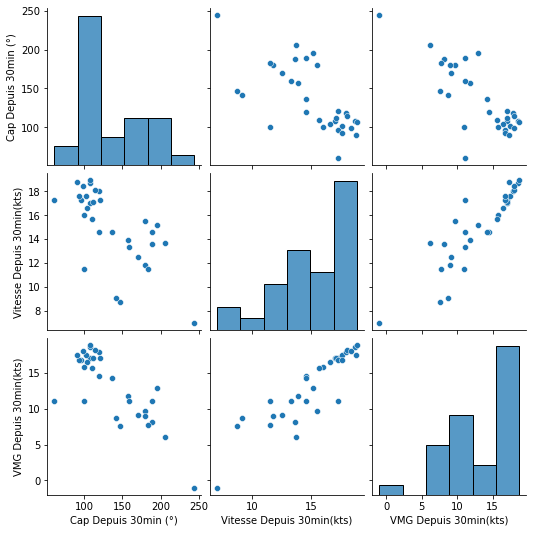

In [260]:
X = pd.DataFrame()
for i in range(len(liste_indices)):
    X[noms[i]] = var_explicatives.iloc[:, i]
sns.pairplot(X) #Pairplot de Seaborn affiche la covariance de chaque variable par rapport à toutes les autres.
plt.show()

Regardons de plus proche leurs correlations avec la variable à expliquer, le Rang

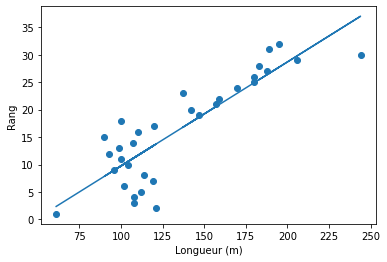

intercept: -9.19 m: 0.19 coeff. de det: 0.74
Plus petit est  Longueur (m) , plus la victoire du bateau est probable 


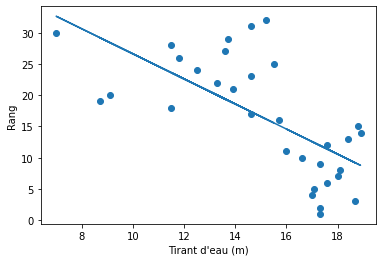

intercept: 46.68 m: -2.01 coeff. de det: 0.45
Plus grand est  Tirant d'eau (m) , plus la victoire du bateau est probable


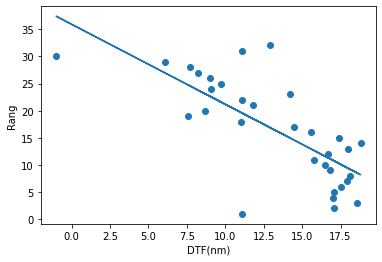

intercept: 35.91 m: -1.47 coeff. de det: 0.55
Plus grand est  DTF(nm) , plus la victoire du bateau est probable


In [261]:
#noms = ['VMG Depuis 30min(kts)', 'VMG Depuis Dernier Class(kts)', 'VMG Depuis 24h(kts)']  
#y = Class_Specs.iloc[:,0]
y = var_a_expliquer
 
for i in range(len(liste_indices)):
    x = var_explicatives.iloc[:, i].tolist()
    x = np.array(x).reshape((-1, 1)).astype(np.float64)
    model = LinearRegression().fit(x,y)
    r_sq = model.score(x, y)
    plt.scatter(x,y)
    y_pred = model.predict(x)
    plt.plot(x, y_pred)
    plt.xlabel(noms[liste_indices[i]])
    plt.ylabel('Rang')
    #plt.title('Classification selon le VMG consideré')
    plt.show()
    print('intercept:', round(model.intercept_,2), 'm:', round(model.coef_[0],2),'coeff. de det:', round(r_sq,2))
    if model.coef_[0] > 0:
        print("Plus petit est ",noms[liste_indices[i]], ", plus la victoire du bateau est probable ")
    else:
        print("Plus grand est ",noms[liste_indices[i]], ", plus la victoire du bateau est probable")

### En utilisant les variables de la méthode de Forward, on calcule:
### 1.- La regression linéaire
### 2.- Le risque de prédiction pour les trois modèles (OLS classique sans PCA, OLS avec PCA, Forward)

In [262]:
XFtrain = pd.DataFrame()
XFtest = pd.DataFrame()

X_traindf = pd.DataFrame(X_train)
X_testdf = pd.DataFrame(X_test)

#Assignation des variables choisies par la méthode Forward à XFtrain et XFtest à partir de Xtrain et Xtest respectivement
for i in range(len(liste_indices)):
    XFtrain[i]=X_traindf.iloc[:,liste_indices[i]]
    XFtest[i]=X_testdf.iloc[:,liste_indices[i]]
    
#Regression linéaire classique sur les variables choisies
olsf = LinearRegression(fit_intercept=True,n_jobs=-1).fit(X=XFtrain,y=y_train)

#Risque calculé à partir des différences entre la prédiction et les valeurs réelles
risque_olsf = sum((y_test - olsf.predict(XFtest))**2)/len(y_test)
print('Risque de prédiction pour OLS avec la méthode de Forward : ',round(risque_olsf,0))

#Comparaison avec d'autres  risques déjà calculés
print('Risque de prédiction pour PCA avant OLS',round(risque_pca_pred,0))
print('Risque de prédiction pour OLS sans PCA',round(risque_ols_pred,0))

Risque de prédiction pour OLS avec la méthode de Forward :  9.0
Risque de prédiction pour PCA avant OLS 29.0
Risque de prédiction pour OLS sans PCA 115.0


Le risque de prédiction est moindre en utilisant la méthode Forward

### Extraction des valeurs de Longitude et Latitude. Graphique des trajectoires

In [263]:
URL = f"https://www.vendeeglobe.org/download-race-data/vendeeglobe_20201109_040000.xlsx"
LatLong = pd.read_excel(URL, usecols ='B,D:G,O', names = ['Rang', 'Skipper', 'Heure','Latitude', 'Longitude', 'Distance (nm)'],
                        skiprows=[0,1,2,3,37,38,39,40]).dropna()
LatLong['Jour'] = '20201109'

for jour in list(range(20201109,20201129)):
    for h in hora:
        URL = f"https://www.vendeeglobe.org/download-race-data/vendeeglobe_{str(jour)}_{h}0000.xlsx"
        if (requests.head(URL).status_code != 404):
            temp = pd.read_excel(URL, usecols ='B,D:G,O', names = ['Rang', 'Skipper', 'Heure','Latitude', 'Longitude', 'Distance (nm)'],
                        skiprows=[0,1,2,3,37,38,39,40]).dropna()
            temp['Jour'] = str(jour)
            LatLong = LatLong.append(temp)
LatLong['Skipper']= LatLong['Skipper'].apply(lambda x : x.split('\n')[0])
LatLong['Heure']= LatLong['Heure'].apply(lambda x : x.split('\n')[0].split("FR")[0])
#LatLong['Jour'] = AUJ
LatLong['Lat'] = LatLong['Latitude'].apply(lambda x: String2Lat(x))
LatLong['Long'] = LatLong['Longitude'].apply(lambda x: String2Long(x))
LatLong['Distance (nm)'] = LatLong['Distance (nm)'].apply(lambda x : x.split(' ')[0])
LatLong['Distance (nm)'] = pd.to_numeric(LatLong['Distance (nm)'],errors='coerce')
LatLong['Jour'] = LatLong['Jour'].apply(lambda x: x[2:4] + "-" + x[4:6] + "-" + x[6:8] + "-")
LatLong['Heure'] = LatLong['Heure'].apply(lambda x:x.split(":")[0] + "-" + x.split(":")[1].strip())
LatLong['DateTime'] = LatLong['Jour']+ LatLong['Heure']
LatLong['DateTime'] = LatLong['DateTime'].apply(lambda x: datetime.datetime.strptime(x, "%y-%m-%d-%H-%M"))
LatLong.head()

,Rang,Skipper,Heure,Latitude,Longitude,Distance (nm),Jour,Lat,Long,DateTime
0,1,Maxime Sorel,05-30,45°55.11'N,06°14.43'W,76.1,20-11-09-,45.918500,-6.240500,2020-11-09 05:30:00
1,2,Jean Le Cam,05-30,45°44.66'N,05°56.55'W,71.1,20-11-09-,45.744333,-5.942500,2020-11-09 05:30:00
2,3,Damien Seguin,05-30,45°53.14'N,06°05.60'W,72.7,20-11-09-,45.885667,-6.093333,2020-11-09 05:30:00
3,4,Jérémie Beyou,05-30,46°24.66'N,07°18.20'W,93.4,20-11-09-,46.411000,-7.303333,2020-11-09 05:30:00
4,5,Nicolas Troussel,05-30,46°30.70'N,07°33.22'W,103.0,20-11-09-,46.511667,-7.553667,2020-11-09 05:30:00


In [270]:
m = Map(basemap=basemaps.Esri.WorldImagery, center=(-30, 0), zoom=1)
dico={}
palette = (sns.color_palette(None, 33)).as_hex()
layers = []
noms = (LatLong['Skipper'].unique()).tolist()
for i, item in enumerate(noms):
    dico[item] = palette[i]
    df1 = LatLong[LatLong['Skipper'] == item]
    locs = []
    for row in df1.iterrows():
        loc = [row[1][7], row[1][8]]
        locs.append(loc)
    icon = Icon(icon_url='https://leafletjs.com/examples/custom-icons/leaf-green.png', icon_size=[10, 30],icon_anchor=[0,0]) 
    marker = Marker(location=(row[1][7], row[1][8]), draggable=False, icon=icon )
    layers.append(marker)
    line = Polyline(locations=locs, color = palette[i], fill = False, weight = 1)
    layer_group = LayerGroup(layers=layers)
    m.add_layer(line)
    m.add_layer(layer_group)
zoom_slider = IntSlider(description='Zoom level:', min=0, max=15, value=2)
jslink((zoom_slider, 'value'), (m, 'zoom'))
widget_control1 = WidgetControl(widget=zoom_slider, position='topright')
m.add_control(widget_control1)
m.save('trajectoires.html', title='Toutes les trajectoires')
m

Map(center=[-30, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

Distance parcourue par chaque Skipper

In [265]:
skipper_group = LatLong.groupby('Skipper')
Dist = (skipper_group.sum()).iloc[:,:1]
Dist.sort_values('Distance (nm)', ascending = False).head(7)

,Distance (nm)
Skipper,
Charlie Dalin,7297.9
Sébastien Simon,6939.3
Kevin Escoffier,6893.9
Louis Burton,6879.9
Thomas Ruyant,6801.4
Samantha Davies,6724.5
Boris Herrmann,6694.0


Distance parcourue par chaque Skipper par rapport à son Rang actuel

In [266]:
Dist_Class = Dist.merge(classif.iloc[:,[0,-1]], on="Skipper", how = 'inner')
Dist_Class.sort_values('Distance (nm)', ascending = False).set_index('Skipper')

,Distance (nm),Rang
Skipper,,
Charlie Dalin,7297.9,1
Kevin Escoffier,6893.9,3
Louis Burton,6879.9,6
Thomas Ruyant,6801.4,2
Samantha Davies,6724.5,11
Boris Herrmann,6694.0,8
Yannick Bestaven,6676.1,5
Alex Thomson,6529.6,15
Giancarlo Pedote,6521.9,10


Nous observons que la correlation entre la postion actuelle et la distance parcourue n'est pas nécesairement linéaire. Par exemple, Sam Davis est le 5ème skipper avec la distance accumulée la plus importante, mais elle n'est que 11ème dans la classification. Cela témoigne de son "irrégularité" ou de son  ineficacité. Pour mieux metre en valeur cette différence, regardons les trajectoires du premier et onzième.

In [271]:
m2 = Map(basemap=basemaps.Esri.WorldImagery, center=(-30, 0), zoom=1)
dico = {}
layers2 = []
palette = ['green', 'red']
noms = ['Charlie Dalin', 'Samantha Davies']
for i, item in enumerate(noms):
    dico[item] = palette[i]
    df2 = LatLong[LatLong['Skipper'] == item]
    locs = []
    for row in df2.iterrows():
        loc = [row[1][7], row[1][8]]
        locs.append(loc)
    icon2 = Icon(icon_url='https://leafletjs.com/examples/custom-icons/leaf-green.png', icon_size=[10, 30],icon_anchor=[0,0]) 
    marker2 = Marker(location=(row[1][7], row[1][8]), draggable=False, icon=icon )
    layers2.append(marker2)
    line2 = Polyline(locations=locs, color = palette[i], fill = False, weight = 1)
    layers2.append(line2)
    layer_group2 = LayerGroup(layers=layers2)
    m2.add_layer(layer_group2)
zoom_slider2 = IntSlider(description='Zoom level:', min=0, max=15, value=3)
jslink((zoom_slider2, 'value'), (m2, 'zoom'))
widget_control2 = WidgetControl(widget=zoom_slider2, position='topright')
m2.add_control(widget_control2)
legend2 = LegendControl(dico, name="Skippers", position="topleft")
m2.add_control(legend2)
m2.save('Difference.html', title='Deux trajectoires')
m2

Map(center=[-30, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

En effet ils ont suivi presque le même parcours, sauf que Samantha Davies s'est fait deviée trop vers l'ouest dans l'Atlantique Sud, peut-être les conditiones meteorologiques le lui ont forcé à faire ce detour.